# Expressing time series as 2D image for CNN

Comparing to methods used in LIGO where time series are expressed/interpreted as spectrograms. Is this a better approach in dealling with label noise and a much more robust techniques? combining normalization and pre-processing in one goal. Difficulties is process power. expressing a 4096 sampling rate into 2 dimensional data and train a CNN, memory issue.

In [1]:
%%time
import numpy as np
import matplotlib.pyplot as plt
from root_pandas import read_root
from sklearn.preprocessing import normalize

plt.rcParams['figure.figsize'] = 10.0, 8.0

file_piled = "Piled_2.root"
# file_flat = "Flat.root"
# file_alpha = "Alpha_11.root"
file_ls = "LS.root"
file_ls_beta = "LS_BETA.root"
file_ref = "RefPulse009.root"

file_230_waveform = "SingleRun.root"
file_230_energy = "Standard_singrun.root"
file_009_energy = "beta_cut_15_dataset.root"
file_009_waveform = "Run009_3Mev_waveform.root"

data = "PMTALL"
tree = "tree"

pmt_all_length = 4480

def NORM(file, tree, data):
    pmtall = read_root(file, tree, columns=[data],flatten=[data])
    num_entries, w = pmtall.shape
    num_entries = int(num_entries/pmt_all_length)
    x = pmtall.PMTALL.values.reshape(num_entries, pmt_all_length)
#     x_abs = abs(x - 15200)
    extra = np.arange(4096, pmt_all_length)
    x_mod = np.delete(x, extra, axis=1)
#     x_nor = normalize(x_mod, norm="l1")
    return x_mod

def differ(x,y):
    for i in range(len(x)):
        x[i] = x[i] - y
    return x

def sep(x, ratio_1, ratio_2, ratio_3, group):
    train = np.zeros((int(len(x)*ratio_1), len(x[0])))
    validation = np.zeros((int(len(x)*ratio_2),len(x[0])))
    test = np.zeros((int(len(x)*ratio_3), len(x[0])))
    for i in range(len(x)):
        if i < int(len(x)*ratio_1):
            train[i] = x[i]
            
        if i >= int(len(x)*ratio_1) and i < int(len(x)*(ratio_2 +ratio_1)):
            k = i - int(len(x)*ratio_1) - 1
            validation[k] = x[i]
            
        if i >= int(len(x)*(ratio_1 + ratio_2)):
            p = i - int(len(x)*(ratio_1 + ratio_2)) - 1
            test[p] = x[i]
        
    train_label = np.zeros(len(train))
    validation_label = np.zeros(len(validation))
    test_label = np.zeros(len(test))
    for i in range(len(train)):
        train_label[i] = group
    for i in range(len(validation)):
        validation_label[i] = group
    for i in range(len(test)):
        test_label[i] = group
    return train, validation, test, train_label, validation_label, test_label

import keras
def data_for_cnn(x1, x2, x3, x4, x5, group):
    x11, x12, x13, x14, x15, x16 = x1
    x21, x22, x23, x24, x25, x26 = x2
    x31, x32, x33, x34, x35, x36 = x3
    x41, x42, x43, x44, x45, x46 = x4
    x51, x52, x53, x54, x55, x56 = x5
#     x61, x62, x63, x64, x65, x66 = x6
    y1 = np.concatenate((x11, x21, x31, x41, x51), axis=0)
    y2 = np.concatenate((x12, x22, x32, x42, x52), axis=0)
    y3 = np.concatenate((x13, x23, x33, x43, x53), axis=0)
    y4 = np.concatenate((x14, x24, x34, x44, x54), axis=0)
    y5 = np.concatenate((x15, x25, x35, x45, x55), axis=0)
    y6 = np.concatenate((x16, x26, x36, x46, x56), axis=0)
    z1 = np.expand_dims(y1, axis=2)
    z2 = np.expand_dims(y2, axis=2)
    z3 = np.expand_dims(y3, axis=2)
    z4 = keras.utils.to_categorical(y4, group)
    z5 = keras.utils.to_categorical(y5, group)
    z6 = keras.utils.to_categorical(y6, group)
    return z1, z2, z3, z4, z5, z6

Welcome to JupyROOT 6.10/02


Using TensorFlow backend.


CPU times: user 4.7 s, sys: 789 ms, total: 5.49 s
Wall time: 7.13 s


In [2]:
%%time
def art1():
    x = np.arange(0,1,0.00025)
    y2 = np.zeros(len(x))
    
    start = np.random.rand(1)*0.02 + 0.1
    sepa = np.random.rand(1)*0.4 + 0.1
    first = np.random.rand(1)*0.1 + 0.9
    mult = np.random.rand(1)
    second = first+mult*first

    fdeca = np.random.rand(1)*5 + 95
    sdeca = np.random.rand(1)*5 + 95
    for i in range(len(x)):
        if i < int(start*len(x)):
            y2[i] = 0.1
        if i >= int(start*len(x)) and i < int(sepa*len(x)):
            y2[i] = first*np.exp(-(x[i]-start)*fdeca) + 0.1
        if i >= int(sepa*len(x)):
            y2[i] = second*np.exp(-(x[i]-sepa)*sdeca) + 0.1
    
    stop = 0.25 + np.random.rand(1)*0.05
    for i in range(len(x)):
        if i< int(start*len(x)):
            y2[i] = y2[i] + np.random.rand(1)*0.02 - 0.01
        if i >= int(start*len(x)) and i < int(stop*len(x)):
            y2[i] = y2[i] + np.random.rand(1)*0.1 - 0.05
        if i >= int(stop*len(x)):
            y2[i] = y2[i] + np.random.rand(1)*0.005 - 0.0025 
    
    ex = np.zeros(160)
    for i in range(160):
        ex[i] = np.random.rand(1)*0.005 - 0.0025 + 0.1
    y2 = np.concatenate((y2,ex),axis=0)
    return y2

def art2():
    x = np.arange(0,1,0.00025)
    y3 = np.zeros(len(x))
    start = np.random.rand(1)*0.02 + 0.1
    sepa = np.random.rand(1)*0.4 + 0.1
    first = np.random.rand(1)*0.1 + 0.9
    mult = np.random.rand(1)
    second = first+mult*first
    
    fslow = np.random.rand(1)*2 + 10 
    sslow = np.random.rand(1)*2 + 10

    y3 = np.zeros(len(x))
    for i in range(len(x)):
        if i < int(start*len(x)):
            y3[i] = 0.1
        if i >= int(start*len(x)) and i < int(sepa*len(x)):
            y3[i] = first*np.exp(-(x[i]-start)*fslow) + 0.1
        if i >= int(sepa*len(x)):
            y3[i] = second*np.exp(-(x[i]-sepa)*sslow) + 0.1 
    
    stop = 0.25 + np.random.rand(1)*0.05
    for i in range(len(x)):
        if i< int(start*len(x)):
            y3[i] = y3[i] + np.random.rand(1)*0.02 - 0.01
        if i >= int(start*len(x)) and i < int(stop*len(x)):
            y3[i] = y3[i] + np.random.rand(1)*0.1 - 0.05
        if i >= int(stop*len(x)):
            y3[i] = y3[i] + np.random.rand(1)*0.005 - 0.0025
    
    ex = np.zeros(160)
    for i in range(160):
        ex[i] = np.random.rand(1)*0.005 - 0.0025 + 0.1
    y3 = np.concatenate((y3,ex),axis=0)
    return y3

print(art1().shape)
artificial = np.zeros((4000,4160))

for i in range(4000):
    if i <2000:
        artificial[i] = art1()
    if i >=2000:
        artificial[i] = art2()
print(artificial.shape)



(4160,)


KeyboardInterrupt: 

In [2]:
%%time

ratio_1 = 0.6
ratio_2 = 0.2
ratio_3 = 0.2

print("Number of entries")

# PMTALL_alpha = NORM(file_alpha, tree, data)
# print("PMTALL_alpha :",len(PMTALL_alpha))
# alpha = sep(PMTALL_alpha, ratio_1, ratio_2, ratio_3, 0)
# del PMTALL_alpha

# PMTALL_ref = NORM(file_ref, tree, data)
# print("PMTALL_ref :",len(PMTALL_ref))
# ref = sep(PMTALL_ref, ratio_1, ratio_2, ratio_3, 1)
# del PMTALL_ref

PMTALL_piled = NORM(file_piled, tree, data)
print("PMTALL_piled :",len(PMTALL_piled))
# piled = sep(PMTALL_piled, ratio_1, ratio_2, ratio_3, 0)
# del PMTALL_piled

# PMTALL_flat = NORM(file_flat, tree, data)
# print("PMTALL_flat :",len(PMTALL_flat))
# flat = sep(PMTALL_flat, ratio_1, ratio_2, ratio_3, 3)
# del PMTALL_flat

# PMTALL_ls = NORM(file_ls, tree, data)
# print("PMTALL_ls :",len(PMTALL_ls))
# ls = sep(PMTALL_ls, ratio_1, ratio_2, ratio_3, 2)
# del PMTALL_ls

# PMTALL_ls_beta = NORM(file_ls_beta, tree, data)
# print("PMTALL_ls_beta :",len(PMTALL_ls_beta))
# ls_beta = sep(PMTALL_ls_beta, ratio_1, ratio_2, ratio_3, 3)
# del PMTALL_ls_beta

# print("Artificial data:",len(artificial))
# fake = sep(artificial, ratio_1, ratio_2, ratio_3, 0)
# del artificial

# typical = NORM("Run009/Run009-079-001.root", tree, data)
# print("test data data:",len(typical))
# fake = sep(artificial, ratio_1, ratio_2, ratio_3, 0)
# del artificial

# classes = 4
# train_data, validation_data, test_data, train_label, validation_label, test_label = data_for_cnn(piled, ls, ls_beta, ref, fake, classes)

# del piled, ls, ls_beta, ref, fake

Number of entries
PMTALL_piled : 2073
CPU times: user 949 ms, sys: 377 ms, total: 1.33 s
Wall time: 1.71 s


# Visualising? not an effective way given memory is an issue, do not store the data but process it on the fly when feeding to the generator class during fitting, the same should be done when checking the 2 dimensional plot.

(256, 256)


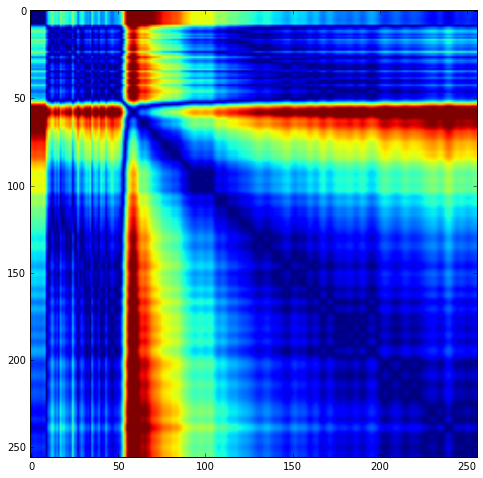

CPU times: user 690 ms, sys: 68.2 ms, total: 759 ms
Wall time: 783 ms


In [33]:
%%time
from skimage.transform import resize
def rec_plot(s, eps=None, steps=None):
    if eps==None: eps=0.01
    if steps==None: steps=10
    N = int(s.size/16)
    P = np.zeros(N)
    for i in np.arange(N):
        P[i] = np.sum(s[int(i*8):int((i+1)*8)])
    S = np.repeat(P[None,:], N, axis=0)
    Z = np.floor(np.abs(S-S.T)/eps)
    Z[Z>steps] = steps
#     Y = resize(Z/steps,(512,512))
    return Z
    
for i in np.random.permutation(len(PMTALL_piled)):
    damn = rec_plot(PMTALL_piled[i],eps=0.00001,steps=800)
    print(damn.shape)
    plt.imshow(damn)
    plt.show()
    break


# Use transfer learning technique, Res-Net, VGG, fine-tuned for this problem of ours.

In [17]:
%%time
from pyts.transformation import MTF, GASF, GADF, RecurrencePlots

# print(PMTALL_piled[:10].shape)

# mtf = MTF(image_size=32, n_bins=10, quantiles='empirical', overlapping=False)
# X_mtf = mtf.transform(PMTALL_piled[:5])

# gasf = GASF(image_size=32, overlapping=False, scale='-1')
# X_gasf = gasf.transform(PMTALL_piled[:5])

# gadf = GADF(image_size=256, overlapping=False, scale='-1')
# X_gadf = gadf.transform(PMTALL_piled[:5])

rp = RecurrencePlots(dimension=3, epsilon='percentage_points', percentage=10)
X_rp = rp.transform(PMTALL_piled[:5])


CPU times: user 4.06 s, sys: 149 ms, total: 4.21 s
Wall time: 4.2 s


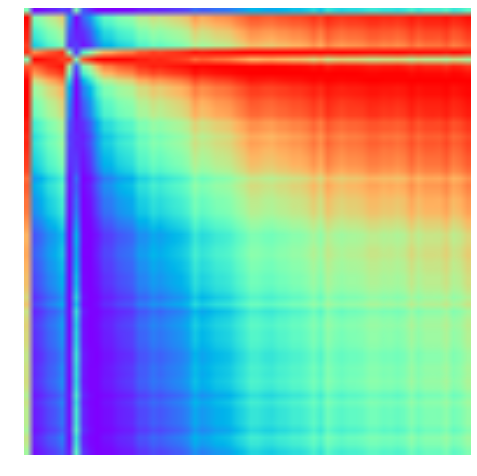

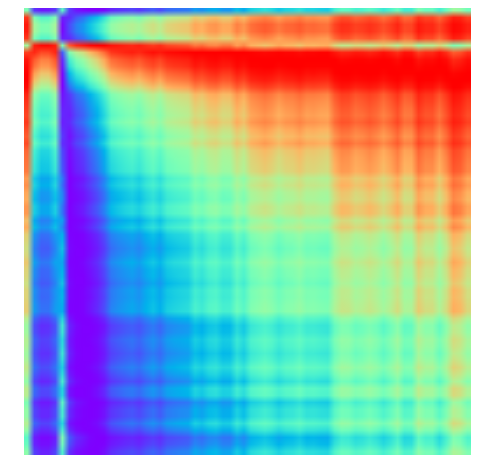

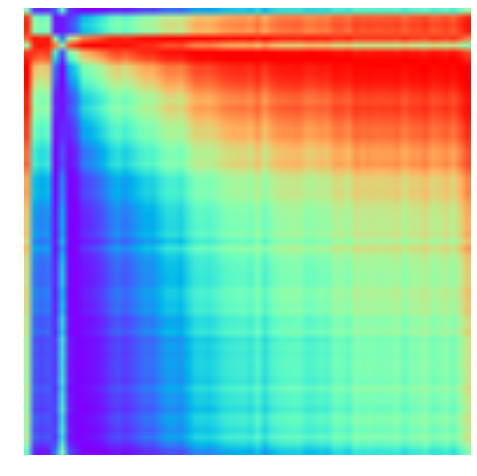

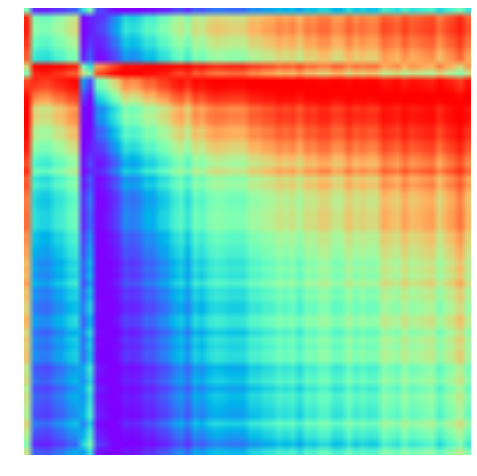

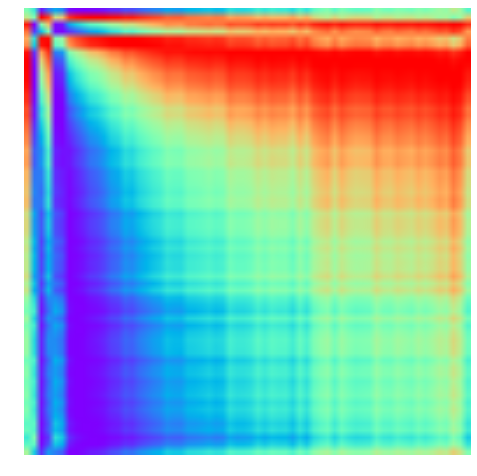

CPU times: user 3.19 s, sys: 206 ms, total: 3.39 s
Wall time: 4.17 s


In [3]:
%%time
from pyts.visualization import plot_mtf, plot_gasf, plot_gadf, plot_recurrence_plots

for i in range(5):
#     plot_mtf(PMTALL_piled[i], image_size=64, n_bins=10, quantiles='empirical', overlapping=False)
#     plt.show()
    plot_gadf(PMTALL_piled[i], image_size=64, overlapping=False, scale='-1')
    plt.show()
#     plot_gadf(PMTALL_piled[i], image_size=64, overlapping=False, scale='-1')
#     plt.show()
#     plot_recurrence_plots(PMTALL_piled[i], dimension=2, epsilon='percentage_points', percentage=10)
#     plt.show()
#     print(X_gadf.shape)
#     plt.imshow(X_gadf[i])
#     plt.show()